### Inspiration from: https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [1]:
import numpy as np
import pandas as pd
import re
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from analysis_functions import *


In [2]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

## loading data

In [3]:
def load_all_tables(directory_path = '', verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading all the tables...")
        #start = datetime.now()
    
    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application
    
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")
       
    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        #print(f'Time Taken to load 8 tables = {datetime.now() - start}')

In [4]:
load_all_tables(directory_path = '../../')

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Done.


In [5]:
application_test.shape

(48744, 121)

In [6]:
installments_payments.shape

(13605401, 8)

## Step by step engineering process from the kaggle notebook:

In [7]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = application_train
    test_df = application_test
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [9]:
df = application_train_test()

Train samples: 307511, test samples: 48744


In [10]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    global bureau
    bureau = bureau
    bb = bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [11]:
bureau = bureau_and_balance()

print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')

Bureau df shape: (305811, 116)


In [12]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [13]:
prev = previous_applications()
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')

Previous applications df shape: (338857, 249)


In [14]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [15]:
pos = pos_cash()
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')

Pos-cash balance df shape: (337252, 18)


In [16]:
# Preprocess installments_payments.csv
def installments_payments_proc(num_rows = None, nan_as_category = True):
    global installment_payments
    ins = installments_payments
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [17]:
ins = installments_payments_proc()
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')

Installments payments df shape: (339587, 26)


In [18]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = cc_balance
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [19]:
cc = credit_card_balance()
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')

Credit card balance df shape: (103558, 141)


## Merged data observations:

In [20]:
df.shape

(356251, 798)

In [21]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
ind = df.index[np.isinf(df).any(1)]
print(ind)

Int64Index([  5687,  60477,  79077,  89018,  98509, 126768, 128791, 140426,
            152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962,
            287300, 292852, 305373, 310339],
           dtype='int64')


In [23]:
df.columns.to_series()[np.isinf(df).any()]

PREV_APP_CREDIT_PERC_MAX          PREV_APP_CREDIT_PERC_MAX
REFUSED_APP_CREDIT_PERC_MAX    REFUSED_APP_CREDIT_PERC_MAX
INSTAL_PAYMENT_PERC_MAX            INSTAL_PAYMENT_PERC_MAX
dtype: object

### there is not enough people with infinite value to call for a specific treatment. we drop them.

In [24]:
df.loc[ind]

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
5687,5687,106652,0.0,1,0,1,0,112500.0,760225.5,30150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60477,60477,170117,0.0,1,1,0,2,140400.0,472500.0,44991.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,12.0
79077,79077,191663,0.0,1,0,0,1,157500.0,225000.0,16501.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,9.0
89018,89018,203360,0.0,0,0,1,0,112500.0,284400.0,16326.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98509,98509,214375,1.0,0,1,1,1,157500.0,484659.0,38857.5,...,1.0,0.020833,2.0,0.020614,0.0,0.0,0.0,0.0,0.0,96.0
126768,126768,247019,0.0,0,1,1,0,135000.0,970380.0,28503.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128791,128791,249387,0.0,0,1,0,0,112500.0,808650.0,26217.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140426,140426,262837,0.0,1,0,0,2,202500.0,1125000.0,33025.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152087,152087,276278,0.0,1,0,1,0,126000.0,728460.0,38938.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167136,167136,293754,0.0,1,1,0,0,256500.0,1129500.0,31189.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df = df.drop(ind, axis = 0)

In [26]:
df[df.isin([np.inf, -np.inf]).any(1)]

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT


In [27]:
ind = df.index[df.isna().any(1)]
print(ind.shape)

(356191,)


In [28]:
df.select_dtypes(include=['object'])

""
0
1
2
3
4
...
356250
356251
356252
356253


In [39]:
df['TARGET'].isna().sum()

48743

In [42]:
#retirer les caractères spéciaux dans feature names pour modèle lgbm
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### We have a thorough cleaning that maintains as many features as possible for maximum performance for the model. However, we face in this project a buisness problem where we want to maintain high performance of the model with high explainability.

### we need to reduce the number of features of our dataset. However, we can't use PCA for dimension reduction as interbretability of the feature would become more difficult.

### We use the Boruta Shap feature selection algorithm for our purpose.

## Boruta Shap feature selection:

In [43]:
from BS import BorutaShap
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer

In [44]:
lgbm = LGBMClassifier()

In [45]:
# split the dataset: train == a une Target; test = n'a pas de Target; validation == partie du train set utilisé pour test
#(train-test split du train set)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

X = train_df.drop(['TARGET'], axis = 1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [46]:
# create a feature selector for a classification problem (0 or 1 client). by default, uses a randomforest classifier for test.
# because we have missing values, and the model with best performance was lgbm, we use it here. then we will compare
# to others in model section.

selector = BorutaShap.BorutaShap(model = lgbm , importance_measure = 'shap', classification = True)

In [47]:
# Fits the selector:
selector.fit(X = X_train, y = y_train, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster // but needs no na so pblm with lgbm

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

62 attributes confirmed important: ['POS_SK_DPD_DEF_MEAN', 'INSTAL_DBD_SUM', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_CREDIT_TYPE_Mortgage_MEAN', 'DAYS_ID_PUBLISH', 'ORGANIZATION_TYPE_Selfemployed', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'EXT_SOURCE_1', 'POS_MONTHS_BALANCE_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'INSTAL_AMT_PAYMENT_MIN', 'NAME_FAMILY_STATUS_Married', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'OWN_CAR_AGE', 'AMT_ANNUITY', 'DAYS_BIRTH', 'ANNUITY_INCOME_PERC', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'DAYS_REGISTRATION', 'EXT_SOURCE_3', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'APPROVED_CNT_PAYMENT_MEAN', 'NAME_INCOME_TYPE_Stateservant', 'PAYMENT_RATE', 'PREV_AMT_DOWN_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_SUM', 'APPROVED_AMT_ANNUITY_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'CODE_GENDER', 'ACTIVE_DAYS_CREDIT_MAX', 'AMT_CREDIT', 'PREV_CNT_PAYMENT_MEAN', 'BURO_CREDIT_

In [49]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(len(features_to_remove))

687


In [50]:
# Removes them from complete dataframe
df_boruta_shap = df.drop(columns = features_to_remove)


In [60]:
df_boruta_shap['ID'] = df['SK_ID_CURR']

In [61]:
df_boruta_shap.head()

,TARGET,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,ID
0,1.0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,NaN,NaN,NaN,100002
1,0.0,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,NaN,NaN,NaN,100003
2,0.0,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,NaN,NaN,NaN,100004
3,0.0,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,NaN,0.0,0.0,100006
4,0.0,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,NaN,NaN,NaN,100007


In [62]:
df_boruta_shap.shape

(356231, 112)

In [63]:
df_boruta_shap.to_csv('selected_feature_dataset', index = False)

### observing features correlation to see if we can keep reducing dimensions:

In [40]:
df = pd.read_csv('selected_feature_dataset')
df.head()

,TARGET,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,ID
0,1.0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,NaN,NaN,NaN,100002
1,0.0,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,NaN,NaN,NaN,100003
2,0.0,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,NaN,NaN,NaN,100004
3,0.0,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,NaN,0.0,0.0,100006
4,0.0,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,NaN,NaN,NaN,100007


In [41]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

----------------------------------------------------------------------------------------------------


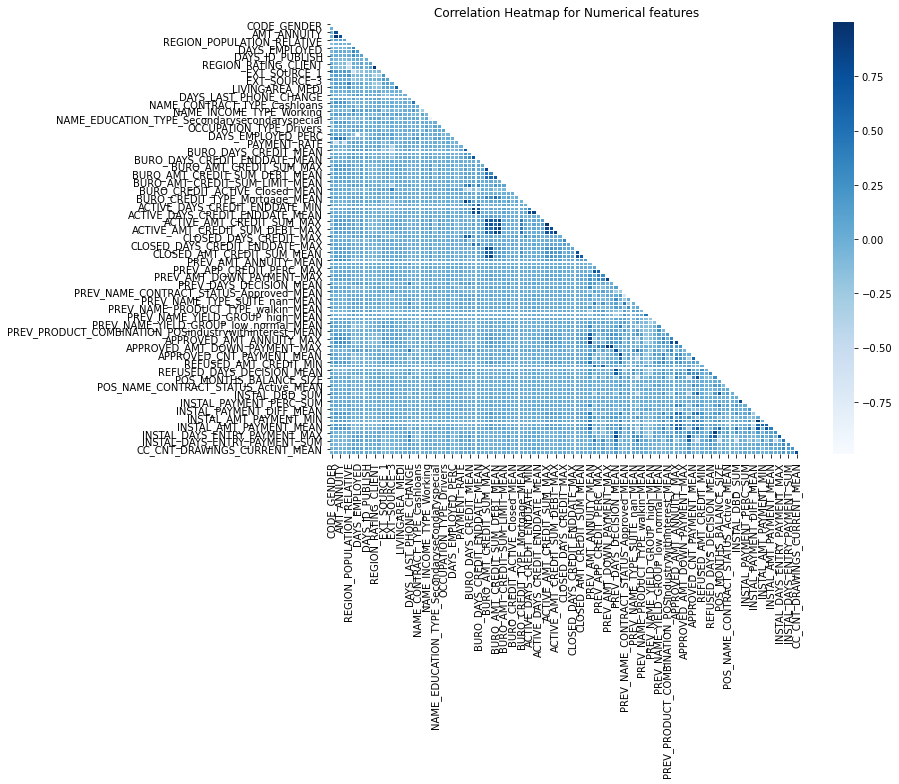

----------------------------------------------------------------------------------------------------


In [42]:
corr_mat = correlation_matrix(df, ['ID'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

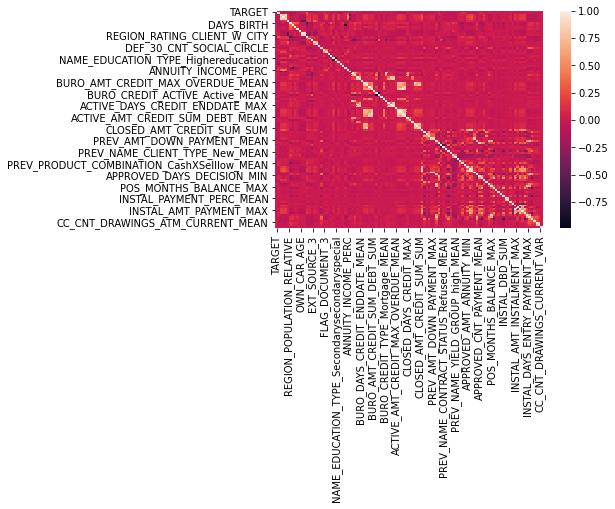

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns

df_correlations = df.corr()

ndf = df_correlations.loc[df_correlations.max(axis=1) > 0.90, df_correlations.max(axis=0) > 0.90]

sns.heatmap(ndf)
plt.show()

matrice des corrélations fortes:


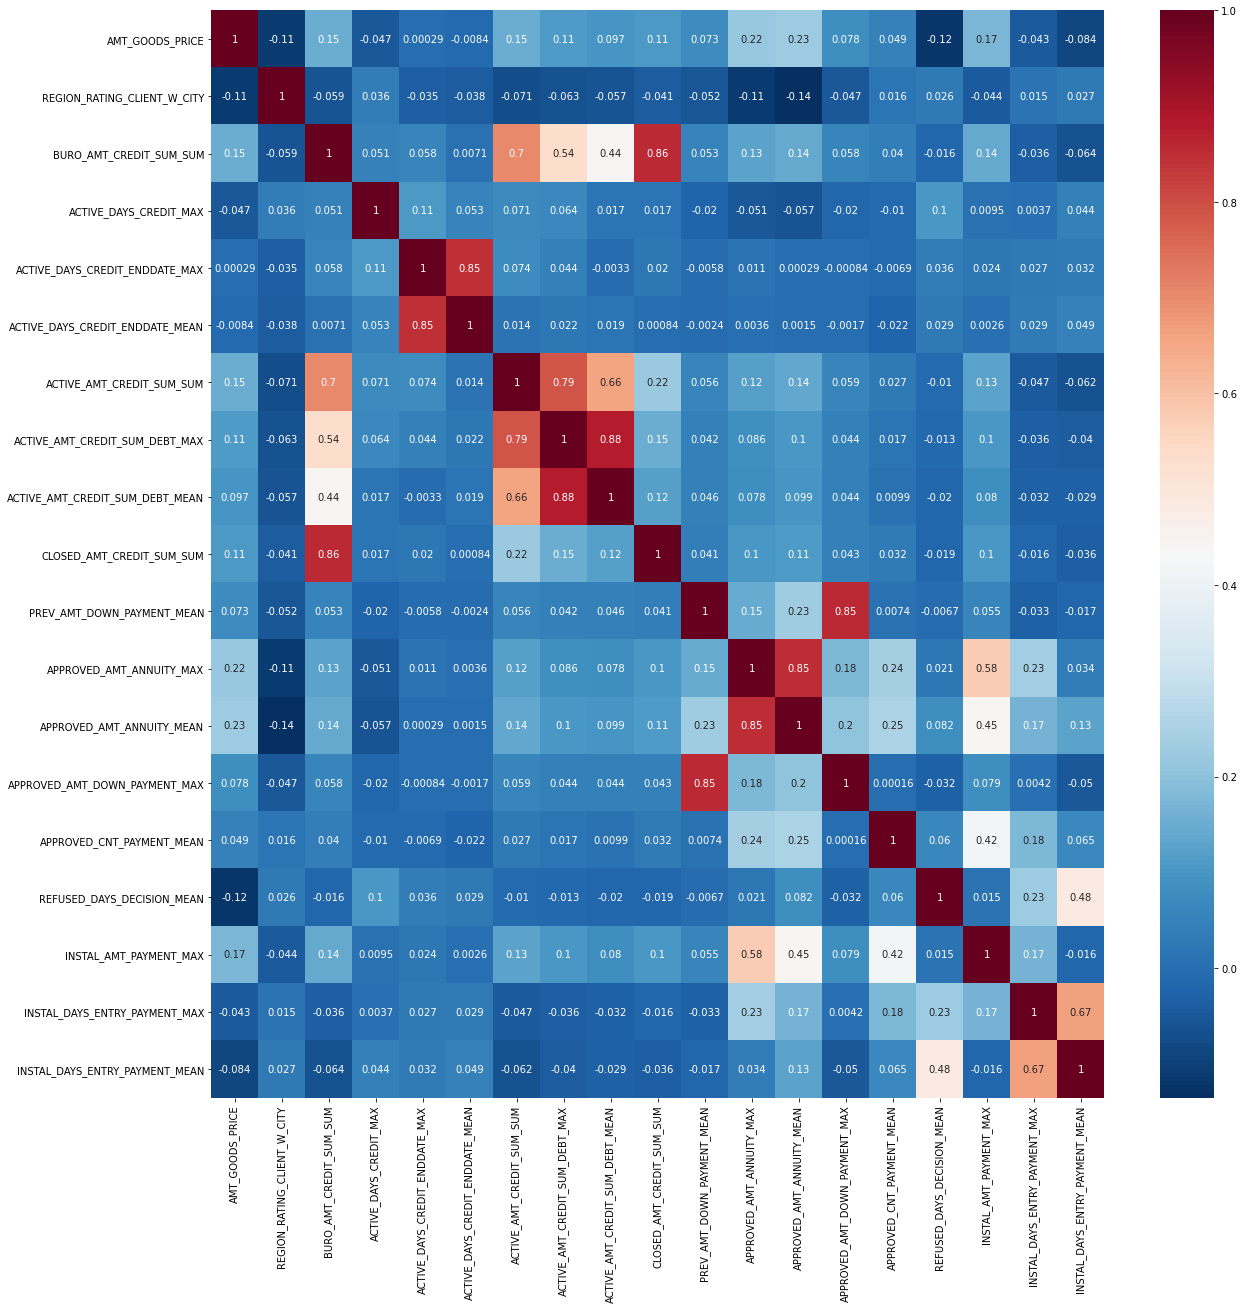

In [44]:

# Creer correlation matrix
mat_cor = df.corr()

# Conserver triangle superieur de correlation matrix
upper = mat_cor.where(np.triu(np.ones(mat_cor.shape), k=1).astype(np.bool))

# trouver les variables avec des corrélations supérieurs à 90%:
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop



#calculer et observer les corrélations entre les variables
print("matrice des corrélations fortes:")
corr_df = df[to_drop].corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, cmap = 'RdBu_r', annot=True)
plt.show()

In [45]:
to_drop

['AMT_GOODS_PRICE',
 'REGION_RATING_CLIENT_W_CITY',
 'BURO_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'REFUSED_DAYS_DECISION_MEAN',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN']

In [46]:
df_1 = df[df['TARGET']==1]
df_0 = df[df['TARGET']==0]

matrice des corrélations fortes:


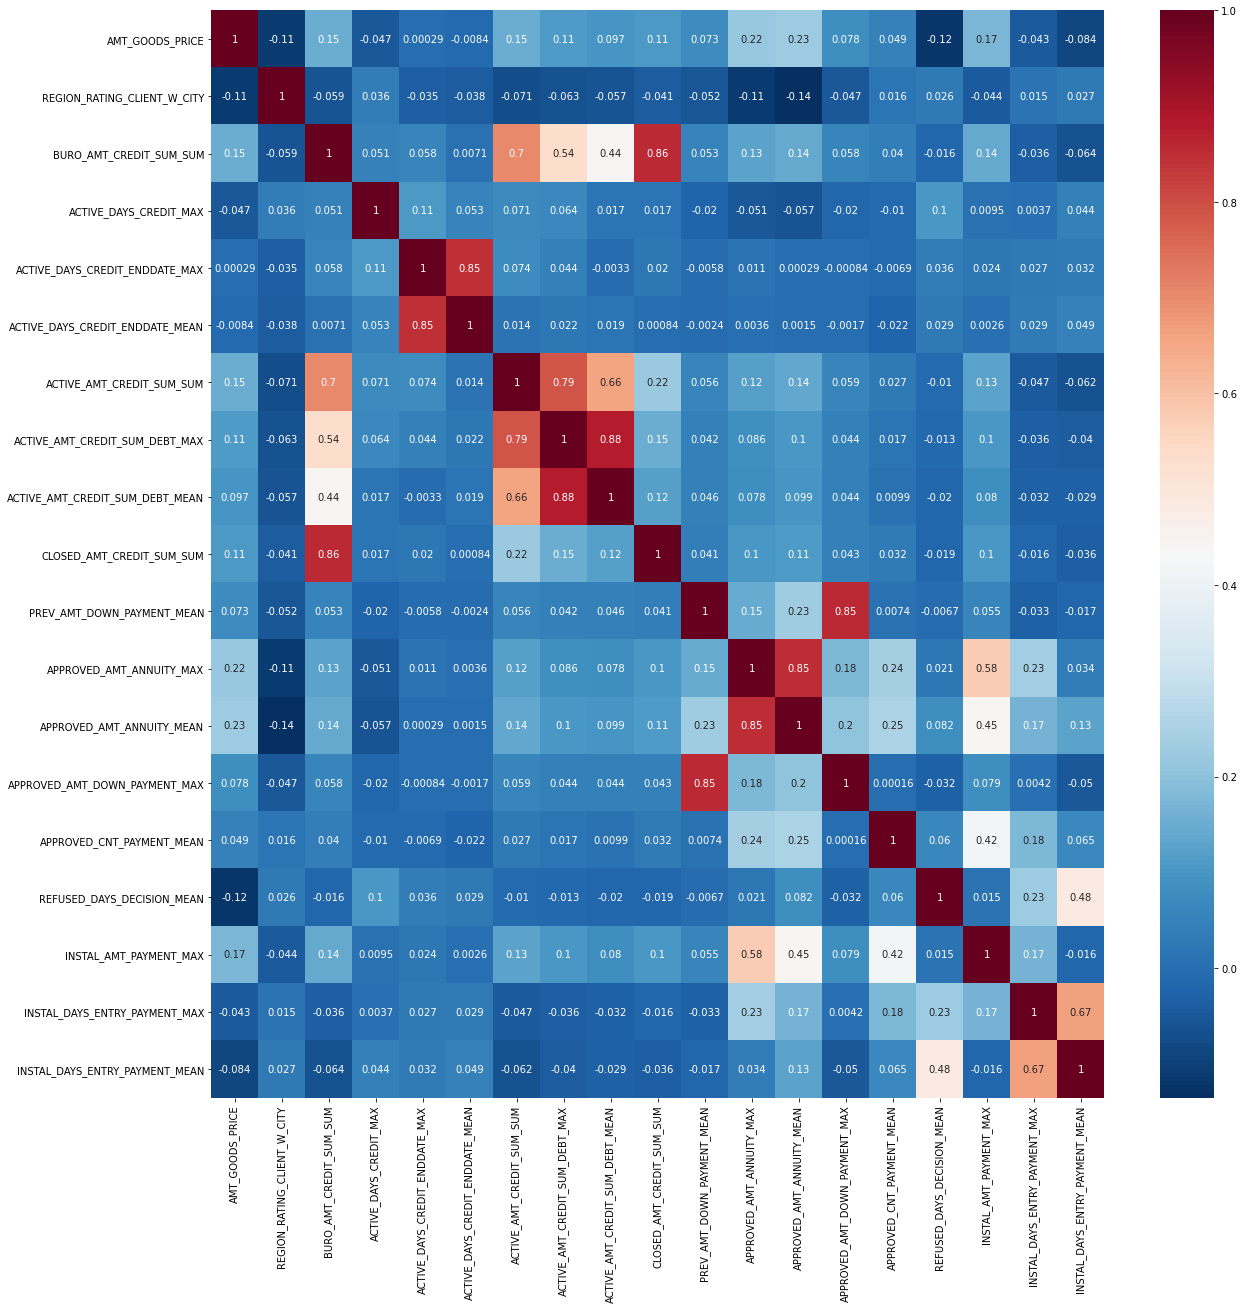

In [47]:
# Creer correlation matrix
mat_cor = df_1.corr()

# Conserver triangle superieur de correlation matrix
upper = mat_cor.where(np.triu(np.ones(mat_cor.shape), k=1).astype(np.bool))

# trouver les variables avec des corrélations supérieurs à 90%:
to_drop_1 = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop_1



#calculer et observer les corrélations entre les variables
print("matrice des corrélations fortes:")
corr_df = df[to_drop].corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, cmap = 'RdBu_r', annot=True)
plt.show()

In [48]:
to_drop_1

['AMT_GOODS_PRICE',
 'REGION_RATING_CLIENT_W_CITY',
 'BURO_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'REFUSED_DAYS_DECISION_MEAN',
 'INSTAL_PAYMENT_PERC_SUM',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_VAR']

matrice des corrélations fortes:


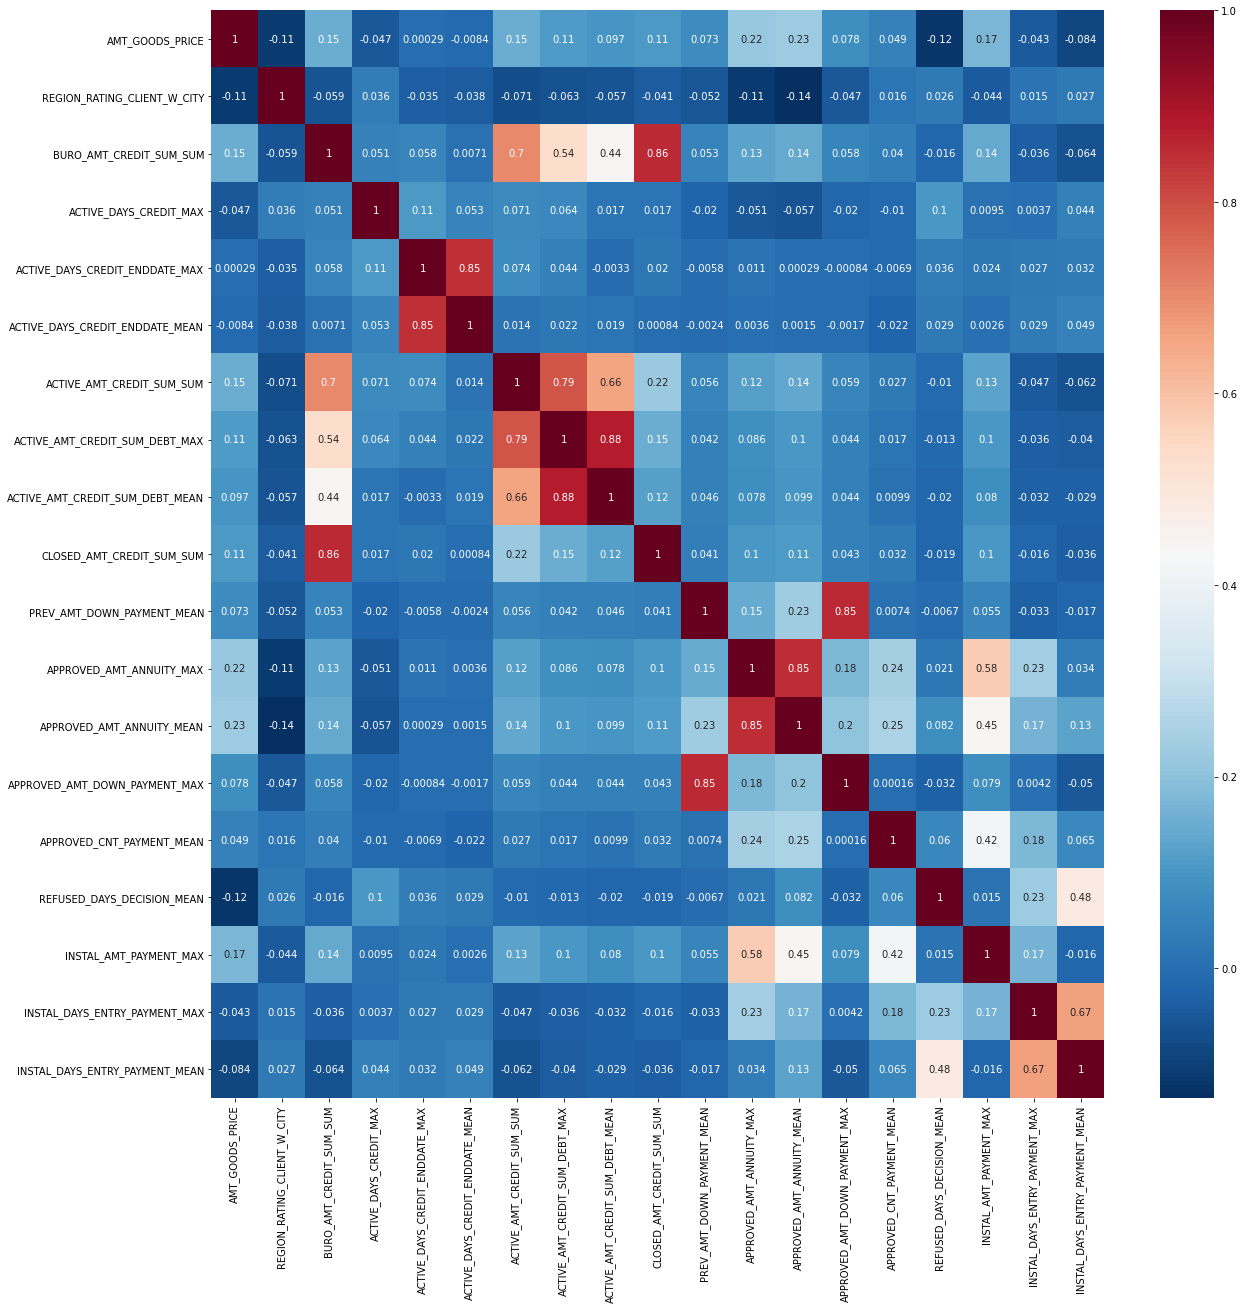

In [49]:
# Creer correlation matrix
mat_cor = df_0.corr()

# Conserver triangle superieur de correlation matrix
upper = mat_cor.where(np.triu(np.ones(mat_cor.shape), k=1).astype(np.bool))

# trouver les variables avec des corrélations supérieurs à 90%:
to_drop_0 = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop_0



#calculer et observer les corrélations entre les variables
print("matrice des corrélations fortes:")
corr_df = df[to_drop].corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, cmap = 'RdBu_r', annot=True)
plt.show()

In [52]:
to_drop_0

['AMT_GOODS_PRICE',
 'REGION_RATING_CLIENT_W_CITY',
 'BURO_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'REFUSED_DAYS_DECISION_MEAN',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN']

In [53]:
set(to_drop) & set(to_drop_1) & set(to_drop_0)

{'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'AMT_GOODS_PRICE',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'REFUSED_DAYS_DECISION_MEAN',
 'REGION_RATING_CLIENT_W_CITY'}

### On peut donc se permettre de retirer quelques features très corrélées pour les deux classes qui potentiellement apportrent la même information.

### On préfére pour le moment laissé les features selectionnée pour leur caractère explicatif potentiel et leur caractère discriminant entre les deux classes (beaucoup sont issues du feature engineering et le max et mean n'est pas nécessairement redondant).

# Annexe: le problème de l'imputation pour la régression logistique:

### there are missing values in the dataset -> lightgbm model doesn't care

### however, we will use different models to compare them. we need an imputation method. 

### two strategies: 

#### either univariate (mean or median) imputation -> we see if the column adds information in its own right. but doesn't take into consideration the buisness case (client selection)

#### or knn imputer: not far fetched to think that a client with a lot of similarities to others would also have same value of the missing data. however - > OHE so we only use the one nearest neighbor.


In [55]:
pre_imputed_df = df_boruta_shap.drop(['TARGET'], axis = 1)

In [56]:
imputer = KNNImputer(n_neighbors = 1)
imputer.fit(pre_imputed_df)

KNNImputer(n_neighbors=1)

## After some testing, we choose univariate median imputer because 1NN imputer is too long and using the mean to impute would distort too much as outliers are important in this project.

In [58]:
simple_imputer = SimpleImputer(strategy='median')

In [ ]:
target = df['TARGET']
imputed_df = imputed_df_median.join(target)